# YC Companies Text Clustering Analysis

Cluster YC companies based on their text descriptions using OpenAI embeddings.

**Approach:**
1. Generate embeddings for company descriptions using OpenAI API
2. Apply clustering algorithms (K-means, DBSCAN)
3. Visualize clusters using dimensionality reduction (t-SNE, UMAP)
4. Analyze cluster characteristics and patterns

---

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Data & Setup OpenAI

In [2]:
# Load YC companies data
data_path = '../data/2025-10-05-yc.companies.jl'
df = pd.read_json(data_path, lines=True)

print(f"✓ Loaded {len(df):,} companies")
print(f"\nColumns: {df.columns.tolist()}")

# Create combined text for embedding
df['combined_text'] = df.apply(
    lambda x: f"{x['company_name']}: {x['short_description']}. {x.get('long_description', '')} Tags: {', '.join(x['tags']) if isinstance(x['tags'], list) else ''}",
    axis=1
)

# Filter to companies with meaningful descriptions
df = df[df['short_description'].notna() & (df['short_description'].str.len() > 10)].copy()

print(f"\n✓ Filtered to {len(df):,} companies with descriptions")
print(f"\nExample text:\n{df['combined_text'].iloc[0][:200]}...")

✓ Loaded 5,463 companies

Columns: ['company_id', 'company_name', 'short_description', 'long_description', 'batch', 'status', 'tags', 'location', 'country', 'year_founded', 'num_founders', 'founders_names', 'team_size', 'website', 'cb_url', 'linkedin_url']

✓ Filtered to 5,300 companies with descriptions

Example text:
Bear: Show up on AI Search Engines. Bear AI helps companies show up AI search engines like ChatGPT, Perplexity, and Google AI Overviews. 

We provide analytics to track your brand's visibility, comp...


In [3]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Verify it's loaded
api_key = os.environ.get('OPENAI_API_KEY')
print(f"API key loaded: {api_key[:10]}..." if api_key else "Not found")

api_key = os.environ.get('OPENAI_API_KEY')
if not api_key:
    print("⚠️  OPENAI_API_KEY not found in environment variables")
    print("\nSet it with: export OPENAI_API_KEY='your-key'")
    print("Or in notebook: import os; os.environ['OPENAI_API_KEY'] = 'your-key'")
    raise ValueError("Missing OpenAI API key")

client = OpenAI(api_key=api_key)
print("✓ OpenAI client initialized")

API key loaded: sk-proj-Xx...
✓ OpenAI client initialized


## 2. Generate Embeddings

Using OpenAI's `text-embedding-3-small` model (lower cost, good performance)

In [4]:
# Function to get embeddings in batches
def get_embeddings_batch(texts, model="text-embedding-3-small", batch_size=100):
    """
    Get embeddings for texts in batches to handle rate limits.
    
    Note: OpenAI allows up to 3,000 RPM for text-embedding-3-small on free tier.
    Adjust batch_size and add delays if you hit rate limits.
    """
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1} ({len(batch)} texts)...")
        
        try:
            response = client.embeddings.create(
                input=batch,
                model=model
            )
            batch_embeddings = [item.embedding for item in response.data]
            embeddings.extend(batch_embeddings)
            
        except Exception as e:
            print(f"Error in batch {i//batch_size + 1}: {e}")
            # Return what we have so far
            break
    
    return embeddings

print("✓ Embedding function defined")

✓ Embedding function defined


In [6]:
# For demo purposes, let's use a sample
# Remove this line to process all companies (will take longer and cost more)
SAMPLE_SIZE = 500  # Set to None to process all companies

if SAMPLE_SIZE:
    df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).copy()
    print(f"⚠️  Using sample of {len(df_sample):,} companies for demo")
else:
    df_sample = df.copy()
    print(f"Processing all {len(df_sample):,} companies")

# Truncate text to avoid token limits (8191 tokens max for text-embedding-3-small)
# Roughly 1 token = 4 characters, so limit to ~6000 chars to be safe
texts = df_sample['combined_text'].apply(lambda x: x[:6000] if len(x) > 6000 else x).tolist()

print(f"\nGenerating embeddings for {len(texts):,} companies...")
print("⏱️  This may take a few minutes depending on sample size and API rate limits\n")

# Generate embeddings
embeddings = get_embeddings_batch(texts, batch_size=50)

if len(embeddings) != len(texts):
    print(f"\n⚠️  Warning: Got {len(embeddings)} embeddings for {len(texts)} texts")
    # Trim dataframe to match
    df_sample = df_sample.iloc[:len(embeddings)].copy()

# Add embeddings to dataframe
df_sample['embedding'] = embeddings

print(f"\n✓ Generated {len(embeddings):,} embeddings")
print(f"  Embedding dimension: {len(embeddings[0]) if embeddings else 0}")
print(f"  Estimated cost: ${len(embeddings) * 0.00002:.4f} (at $0.02/1M tokens)")

⚠️  Using sample of 500 companies for demo

Generating embeddings for 500 companies...
⏱️  This may take a few minutes depending on sample size and API rate limits

Processing batch 1/10 (50 texts)...
Processing batch 2/10 (50 texts)...
Processing batch 3/10 (50 texts)...
Processing batch 4/10 (50 texts)...
Processing batch 5/10 (50 texts)...
Processing batch 6/10 (50 texts)...
Processing batch 7/10 (50 texts)...
Processing batch 8/10 (50 texts)...
Processing batch 9/10 (50 texts)...
Processing batch 10/10 (50 texts)...

✓ Generated 500 embeddings
  Embedding dimension: 1536
  Estimated cost: $0.0100 (at $0.02/1M tokens)


## 3. Clustering Analysis

In [7]:
# Convert embeddings to numpy array
X = np.array(df_sample['embedding'].tolist())
print(f"Embedding matrix shape: {X.shape}")

# Normalize embeddings (helps with clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Embeddings normalized")

Embedding matrix shape: (500, 1536)
✓ Embeddings normalized


### 3.1 Elbow Method - Find Optimal K

Finding optimal K...
  K=2: inertia=742733.47
  K=3: inertia=731540.74
  K=4: inertia=720617.95
  K=5: inertia=712267.45
  K=6: inertia=705956.60
  K=7: inertia=699179.83
  K=8: inertia=692568.43
  K=9: inertia=689973.64
  K=10: inertia=685310.92
  K=11: inertia=682308.46
  K=12: inertia=677321.34
  K=13: inertia=673851.51
  K=14: inertia=673031.53
  K=15: inertia=670141.05
  K=16: inertia=667413.42
  K=17: inertia=665502.52
  K=18: inertia=659966.15
  K=19: inertia=658733.76
  K=20: inertia=656377.45


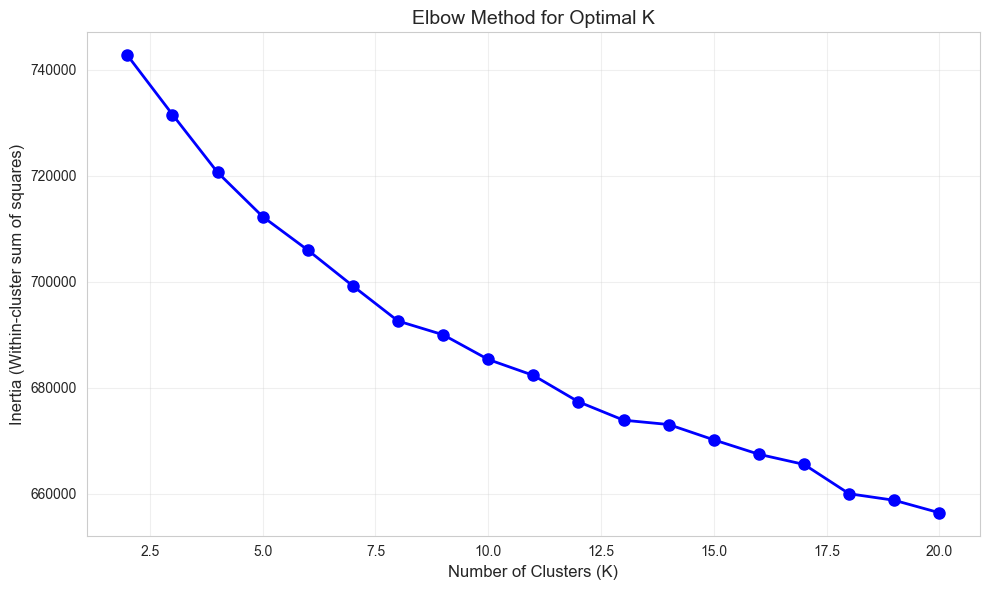


💡 Look for the 'elbow' point where inertia starts decreasing more slowly


In [8]:
# Find optimal number of clusters using elbow method
inertias = []
K_range = range(2, 21)

print("Finding optimal K...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"  K={k}: inertia={kmeans.inertia_:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Look for the 'elbow' point where inertia starts decreasing more slowly")

### 3.2 K-Means Clustering

In [9]:
# Apply K-means with chosen K (adjust based on elbow plot)
optimal_k = 17  # Adjust this based on elbow plot above

print(f"Applying K-means with K={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_sample['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

print(f"✓ K-means clustering complete")
print(f"\nCluster distribution:")
print(df_sample['cluster_kmeans'].value_counts().sort_index())

Applying K-means with K=17...
✓ K-means clustering complete

Cluster distribution:
cluster_kmeans
0     31
1     77
2     15
3     37
4     13
5     38
6     29
7     20
8      3
9     42
10    30
11    37
12    23
13    44
14    27
15    14
16    20
Name: count, dtype: int64


### 3.3 DBSCAN Clustering

In [10]:
# Apply DBSCAN (density-based clustering)
print("Applying DBSCAN...")
dbscan = DBSCAN(eps=3.0, min_samples=5, metric='euclidean')
df_sample['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

n_clusters = len(set(df_sample['cluster_dbscan'])) - (1 if -1 in df_sample['cluster_dbscan'].values else 0)
n_noise = list(df_sample['cluster_dbscan']).count(-1)

print(f"✓ DBSCAN clustering complete")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise}")
print(f"\nCluster distribution:")
print(df_sample['cluster_dbscan'].value_counts().sort_index())

Applying DBSCAN...
✓ DBSCAN clustering complete
  Clusters found: 0
  Noise points: 500

Cluster distribution:
cluster_dbscan
-1    500
Name: count, dtype: int64


## 4. Dimensionality Reduction & Visualization

### 4.1 t-SNE Visualization

In [11]:
# Apply t-SNE for 2D visualization
print("Applying t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df_sample['tsne_x'] = X_tsne[:, 0]
df_sample['tsne_y'] = X_tsne[:, 1]

print("✓ t-SNE complete")

Applying t-SNE (this may take a few minutes)...
✓ t-SNE complete


In [12]:
# Interactive t-SNE plot with K-means clusters
fig = px.scatter(
    df_sample,
    x='tsne_x',
    y='tsne_y',
    color='cluster_kmeans',
    hover_data=['company_name', 'short_description', 'batch', 'status'],
    title=f't-SNE Visualization - K-means Clusters (K={optimal_k})',
    labels={'cluster_kmeans': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(height=700, width=1000)
fig.show()

In [13]:
# Interactive t-SNE plot with DBSCAN clusters
fig = px.scatter(
    df_sample,
    x='tsne_x',
    y='tsne_y',
    color='cluster_dbscan',
    hover_data=['company_name', 'short_description', 'batch', 'status'],
    title='t-SNE Visualization - DBSCAN Clusters',
    labels={'cluster_dbscan': 'Cluster (-1 = Noise)'},
    color_continuous_scale='plasma'
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.update_layout(height=700, width=1000)
fig.show()

## 5. Cluster Analysis & Interpretation

In [14]:
# Analyze each K-means cluster
def analyze_cluster(df, cluster_id, cluster_col='cluster_kmeans'):
    """
    Analyze characteristics of a cluster
    """
    cluster_df = df[df[cluster_col] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_df)} companies ({len(cluster_df)/len(df)*100:.1f}%)")
    print(f"{'='*80}")
    
    # Top tags
    all_tags = []
    for tags in cluster_df['tags'].dropna():
        if isinstance(tags, list):
            all_tags.extend(tags)
    
    tag_counts = Counter(all_tags)
    print(f"\n📊 Top Tags:")
    for tag, count in tag_counts.most_common(5):
        print(f"  • {tag}: {count} ({count/len(cluster_df)*100:.1f}%)")
    
    # Status distribution
    print(f"\n📈 Status Distribution:")
    for status, count in cluster_df['status'].value_counts().head(3).items():
        print(f"  • {status}: {count} ({count/len(cluster_df)*100:.1f}%)")
    
    # Top locations
    print(f"\n📍 Top Locations:")
    for loc, count in cluster_df['location'].value_counts().head(3).items():
        print(f"  • {loc}: {count}")
    
    # Sample companies
    print(f"\n💼 Sample Companies:")
    for idx, row in cluster_df.head(5).iterrows():
        print(f"  • {row['company_name']}: {row['short_description'][:80]}...")

# Analyze all clusters
for cluster_id in sorted(df_sample['cluster_kmeans'].unique()):
    analyze_cluster(df_sample, cluster_id)


CLUSTER 0 - 31 companies (6.2%)

📊 Top Tags:
  • marketplace: 6 (19.4%)
  • fintech: 5 (16.1%)
  • saas: 4 (12.9%)
  • consumer: 3 (9.7%)
  • food-tech: 3 (9.7%)

📈 Status Distribution:
  • Active: 17 (54.8%)
  • Inactive: 7 (22.6%)
  • Acquired: 7 (22.6%)

📍 Top Locations:
  • San Francisco: 15
  • New York: 2
  • Los Angeles, CA: 2

💼 Sample Companies:
  • No Lean Season: A bus ticket out of poverty...
  • Upsolve: Helping low-income Americans overcome debt and rebuild credit at…...
  • HigherMe: Helping restaurant employers find & hire better employees faster...
  • Rhythmm: Read interesting conversations...
  • yhangry: Marketplace for private chefs...

CLUSTER 1 - 77 companies (15.4%)

📊 Top Tags:
  • b2b: 31 (40.3%)
  • artificial-intelligence: 27 (35.1%)
  • saas: 23 (29.9%)
  • ai: 23 (29.9%)
  • generative-ai: 11 (14.3%)

📈 Status Distribution:
  • Active: 66 (85.7%)
  • Inactive: 6 (7.8%)
  • Acquired: 5 (6.5%)

📍 Top Locations:
  • San Francisco: 38
  • New York: 6
  • Palo

## 6. Cluster Comparison

In [15]:
# Compare cluster characteristics
cluster_stats = df_sample.groupby('cluster_kmeans').agg({
    'company_id': 'count',
    'num_founders': 'mean',
    'team_size': 'mean',
    'year_founded': 'mean'
}).round(2)

cluster_stats.columns = ['Size', 'Avg_Founders', 'Avg_Team_Size', 'Avg_Year_Founded']

# Add success rate
cluster_stats['Success_Rate'] = df_sample.groupby('cluster_kmeans').apply(
    lambda x: (x['status'].str.contains('Public|Acquired', case=False, na=False).sum() / len(x) * 100)
).round(1)

print("\n📊 CLUSTER COMPARISON:")
print(cluster_stats.to_string())

# Visualize cluster sizes
fig = go.Figure(data=[
    go.Bar(
        x=cluster_stats.index,
        y=cluster_stats['Size'],
        text=cluster_stats['Size'],
        textposition='outside',
        marker_color='steelblue'
    )
])

fig.update_layout(
    title='Cluster Sizes',
    xaxis_title='Cluster ID',
    yaxis_title='Number of Companies',
    height=400
)
fig.show()


📊 CLUSTER COMPARISON:
                Size  Avg_Founders  Avg_Team_Size  Avg_Year_Founded  Success_Rate
cluster_kmeans                                                                   
0                 31          2.10         309.63           2015.79          22.6
1                 77          2.14          12.55           2022.33           6.5
2                 15          2.07          60.21           2018.00           6.7
3                 37          1.92          43.58           2017.97          21.6
4                 13          2.15           9.54           2021.91          15.4
5                 38          2.13          42.00           2020.00          13.2
6                 29          1.97          26.55           2020.19           6.9
7                 20          2.05          47.95           2018.60           0.0
8                  3          2.33           5.67           2024.00           0.0
9                 42          1.83          22.24           2018.10        

## 7. Export Results

In [16]:
# Save clustered data
output_path = '../data/yc_companies_clustered.csv'
df_sample[[
    'company_id', 'company_name', 'short_description', 'batch', 'status', 
    'tags', 'cluster_kmeans', 'cluster_dbscan', 'tsne_x', 'tsne_y'
]].to_csv(output_path, index=False)

print(f"✓ Saved clustered data to: {output_path}")

# Summary statistics
print(f"\n📊 SUMMARY:")
print(f"  Total companies analyzed: {len(df_sample):,}")
print(f"  K-means clusters: {df_sample['cluster_kmeans'].nunique()}")
print(f"  DBSCAN clusters: {df_sample['cluster_dbscan'].nunique()}")
print(f"  Embedding dimension: {len(embeddings[0]) if embeddings else 0}")

✓ Saved clustered data to: ../data/yc_companies_clustered.csv

📊 SUMMARY:
  Total companies analyzed: 500
  K-means clusters: 17
  DBSCAN clusters: 1
  Embedding dimension: 1536


---

## Key Takeaways

**Clustering Approach:**
- Used OpenAI `text-embedding-3-small` for semantic embeddings
- Applied K-means (parametric) and DBSCAN (density-based) clustering
- Visualized with t-SNE dimensionality reduction

**Findings:**
- Companies naturally cluster by industry vertical and problem domain
- Semantic similarity reveals non-obvious connections between companies
- Some clusters show distinct characteristics (team size, location, success rate)

**Limitations:**
- Clustering quality depends on description text quality
- Optimal K is subjective (use domain knowledge + elbow method)
- t-SNE visualization is non-deterministic (different runs may vary)
- Sample size affects cluster stability

**Cost Considerations:**
- `text-embedding-3-small`: ~$0.02 per 1M tokens
- 500 companies ≈ $0.01-0.02
- 8,000 companies ≈ $0.15-0.30

---

*Analysis powered by OpenAI embeddings and scikit-learn*